In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip, imap
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point

In [4]:
from IPython.display import IFrame

In [5]:
import theano_models as tm
from theano_models.util.theano_helpers import independent_subgraphs, list_random_sources
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm

In [6]:
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
tm.inputting_references.update(['to_be_randomized'])
tm.inputting_references, tm.outputting_references

({'extra_inputs',
  'flat',
  'inputs',
  'n_data',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'loglikelihood', 'norm_det', 'norm_dets', 'outputs'})

# model

In [9]:
g1 = pm.Gauss(2)
g1

Gauss { 'inputs': [],
  'outputs': Gauss.outputs,
  'parameters': [mean],
  'parameters_positive': [var]}

In [10]:
g2 = pm.Gauss(2)
g2

Gauss2 { 'inputs': [],
  'outputs': Gauss2.outputs,
  'parameters': [mean],
  'parameters_positive': [var]}

In [11]:
model = pm.Mixture(g1, g2)
model

Mixture { 'inputs': [],
  'outputs': Mixture.outputs,
  'parameters': [mean, mean],
  'parameters_positive': [var, var],
  'parameters_psumto1': [mixture_probs]}

In [12]:
model = tm.Merge(model,
    tm.Reparameterize(model['parameters_positive'], tm.squareplus, tm.squareplus_inv),
    tm.Reparameterize(model['parameters_psumto1'], tm.softmax, tm.softmax_inv)
); model

Merge4 { 'inputs': [],
  'outputs': Mixture.outputs,
  'parameters': [ mean,
                  mean,
                  var_squareplus,
                  var_squareplus,
                  mixture_probs_softmax],
  'parameters_positive': [],
  'parameters_psumto1': []}

In [13]:
model = tm.Merge(model, tm.Flatten(model['parameters']))
model

Merge5 { 'flat': "mean:mean:var_squareplus:var_squareplus:mixture_probs_softmax",
  'inputs': [],
  'outputs': Mixture.outputs,
  'parameters': [],
  'parameters_positive': [],
  'parameters_psumto1': []}

# Target

In [14]:
t1 = pm.Gauss(init_mean=[1,1], init_var=0.5)
t2 = pm.Gauss(init_mean=[0,4], init_var=0.1)
target = pm.Mixture(t1, t2, init_mixture_probs=[0.2, 0.8])
target

Mixture2 { 'inputs': [],
  'outputs': Mixture2.outputs,
  'parameters': [mean, mean],
  'parameters_positive': [var, var],
  'parameters_psumto1': [mixture_probs]}

In [15]:
sampler = target.function()

In [16]:
training = np.array([sampler() for _ in range(5000)])
print training[:10]

validation = np.array([sampler() for _ in range(100)])
print validation[:10]

[[  3.66113942e-01   4.01523521e+00]
 [ -7.16948635e-01   4.23222385e+00]
 [  1.79059883e-01   3.92518424e+00]
 [  5.66205919e-01   3.80013605e+00]
 [ -7.00765256e-04   3.89136391e+00]
 [ -2.50045844e-01   4.40897761e+00]
 [  2.04482357e+00   5.08960273e-01]
 [ -1.32550118e-01   4.34355612e+00]
 [  7.15468262e-01   3.83803496e+00]
 [  1.19253098e+00   2.55445250e+00]]
[[ 0.01942676  4.19575528]
 [ 0.53759475  3.70719834]
 [ 0.87700022  0.56390252]
 [ 0.08898868  3.95687162]
 [ 0.3064754   0.38957751]
 [-0.34762369  3.73315812]
 [ 0.08033131  4.66807104]
 [ 0.18062283  3.76214084]
 [-0.21275366  4.32411419]
 [ 0.30108797  3.57858481]]


# Optimizer

In [18]:
loss = tm.loss_probabilistic(model)

In [20]:
optimizer_kwargs = tm.numericalize(loss, model['flat'],
    batch_mapreduce=meanmap,
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.size, scale=0.01),
)

In [21]:
batch_size = 200
n_batches = training.shape[0] // batch_size  # after this many steps we went through the whole data set once
climin_args = izip(
    imap(lambda a: (a,), chunk(batch_size, cycle(training))),  # args iterator (needs to return tuple!!)
    repeat({})  # kwargs iterator
)

In [22]:
opt = optimizer(
    identifier="adadelta",
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adadelta.Adadelta'>
  % (i, klass))


<IPython.core.display.Javascript object>


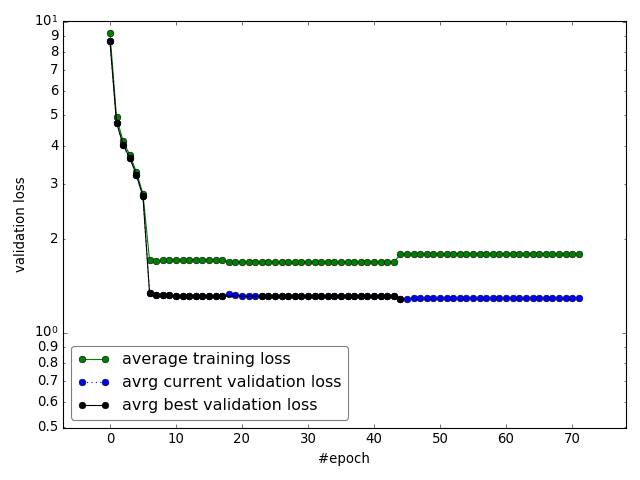

In [25]:
line_train, = plot([], [], 'go-', label="average training loss")
line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
ylabel("validation loss")
gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
xlabel("#epoch")
legend(loc='lower left', fancybox=True, framealpha=0.5)

best_val_loss = optimizer_kwargs['num_loss'](opt.wrt, validation) #/val_size
training_loss = optimizer_kwargs['num_loss'](opt.wrt, training[:10])
add_point(line_best_val, 0, best_val_loss)  
add_point(line_curr_val, 0, best_val_loss)
add_point(line_train, 0, training_loss)

In [29]:
# best_val_loss = inf
best_wrt = None

max_epochs_without_improvement = 10  # taken from UncertainWeightsPaper
epoch_last_improvement = opt.n_iter//n_batches

for info in every(n_batches, opt):
    current_epoch = info['n_iter']//n_batches
    if current_epoch - epoch_last_improvement > max_epochs_without_improvement:
        break
    # collect and visualize validation loss for choosing the best model
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, validation) #/val_size
    if val_loss < best_val_loss:
        epoch_last_improvement = current_epoch
        best_wrt = opt.wrt
        best_val_loss = val_loss
        add_point(line_best_val, current_epoch, val_loss)
    add_point(line_curr_val, current_epoch, val_loss)
    
    # visualize training loss for comparison:
    try:
        training_loss = info['loss'] #/ len(Z)  # TODO normalization needed?
    except KeyError:
        training_loss = optimizer_kwargs['num_loss'](opt.wrt, training[:10]) #/len(Z)
    add_point(line_train, current_epoch, training_loss)
    
#     print info['n_iter'], training_loss, val_loss, best_val_loss

KeyboardInterrupt: 

In [27]:
f_parameters = theano.function([model['flat']],
                               [g1.mean, t1.mean,
                                g2.mean, t2.mean,
                                g1.var, t1.var,
                                g2.var, t2.var,
                                model.mixture_probs, target.mixture_probs])
parameters = f_parameters(best_wrt)
print "%30s ~ target" % "fit"
for c in chunk_list(2, parameters):
    print "%30s ~ %s" % tuple(c)

                           fit ~ target
     [-0.03102252  4.01111364] ~ [ 1.  1.]
     [ 1.03174293  0.98311527] ~ [ 0.  4.]
               0.0916900998019 ~ 0.5
                0.587293886013 ~ 0.1
     [ 0.80336041  0.19663959] ~ [ 0.2  0.8]
